In [8]:
import eleanor
import numpy as np
import lightkurve as lk
from matplotlib import pyplot as plt
import tqdm
import scipy.optimize as sopt
from scipy.special import iv
from zernike import RZern, FitZern
import torch
from torch.autograd import grad as tgrad
%load_ext autoreload
%autoreload 2

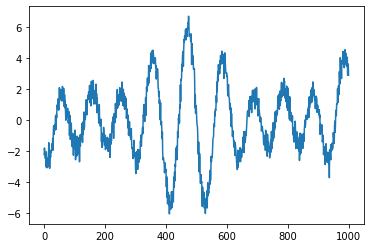

In [9]:
# make some synth data
# i want it to be a transit later so that I can get a CDPP
# but just for method validation let's use a sine wave

nstars = 3
amps = np.array([1, 2, 3])
freqs = np.array([0.04, 0.05, 0.06])
phis = np.pi * np.array([1, 2, 3]) / 2
t = np.arange(0, 1000)
fluxes = np.vstack((a * np.sin(f * t + p) for a, f, p in zip(amps, freqs, phis)))
fluxes_m = fluxes + np.random.normal(0, 0.25, fluxes.shape)
plt.plot(np.sum(fluxes_m.T, axis=1))

In [35]:
shape = (11, 11)
xr = np.arange(shape[0]) - (shape[0] // 2)
yr = np.arange(shape[1]) - (shape[1] // 2)
x, y = np.meshgrid(xr, yr)
xc = [3.0, 5.0, 6.5]
yc = [9.5, 2.4, 7.3]
star = eleanor.Source(tic=120362128, sector=14, tc=True)
prf = eleanor.prf.make_prf_from_source(star)
psf_shape = (117, 117)
psf_xr = np.arange(psf_shape[0]) - (psf_shape[0] // 2)
psf_yr = np.arange(psf_shape[1]) - (psf_shape[1] // 2)
psf_x, psf_y = np.meshgrid(psf_xr, psf_yr)

In [27]:
prf_cut = prf[58-13:58+14,58-13:58+14]

In [28]:
def twoD_Gaussian(coords, A, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = np.cos(theta) ** 2/(2 * sigma_x**2) + np.sin(theta) ** 2 /(2 * sigma_y**2)
    b = np.sin(2 * theta) * (1 / sigma_y ** 2 - 1 / sigma_x ** 2) / 4
    c = np.sin(theta) ** 2/(2 * sigma_x**2) + np.cos(theta) ** 2 /(2 * sigma_y**2)
    dx, dy = coords[0] - xo, coords[1] - yo
    g = offset + A*np.exp(-(a * dx ** 2 - 2 * b * dx * dy + c * dy ** 2))
    return g.ravel()

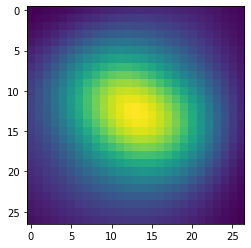

In [29]:
plt.imshow(prf_cut)

In [36]:
popt, pcov = sopt.curve_fit(twoD_Gaussian, (psf_x[58-13:58+14,58-13:58+14], psf_y[58-13:58+14,58-13:58+14]), prf_cut.ravel(), p0=(1,0,0,1,1,0,0))


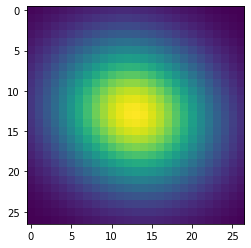

In [37]:
plt.imshow(twoD_Gaussian((psf_x[58-13:58+14,58-13:58+14], psf_y[58-13:58+14,58-13:58+14]), *popt).reshape(27,27))

In [38]:
popt

array([ 0.22769676, -0.23412051, -0.17997752,  6.95241628,  6.19726702,
        6.7235619 ,  0.00940619])

In [39]:
residual = twoD_Gaussian((psf_x[58-13:58+14,58-13:58+14], psf_y[58-13:58+14,58-13:58+14]), *popt).reshape(27,27) - prf_cut

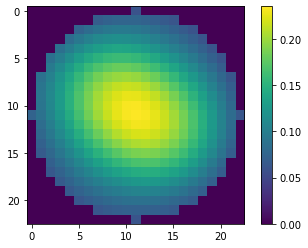

In [40]:
pol = RZern(6)
pol.make_cart_grid(*np.meshgrid(np.linspace(-1, 1, 23), np.linspace(-1, 1, 23)), unit_circle=True)
pol.ZZ = np.nan_to_num(pol.ZZ, 0)
prf_cut_circ = prf_cut[2:-2,2:-2] * pol.ZZ[:,0].reshape(23,23)
x, res, rank, sv = np.linalg.lstsq(pol.ZZ, (prf_cut_circ.flatten()))
plt.imshow((pol.ZZ @ x).reshape(23,23))
plt.colorbar()
ZZ = np.nan_to_num(pol.ZZ, 0)

In [41]:
res

array([0.00015439])

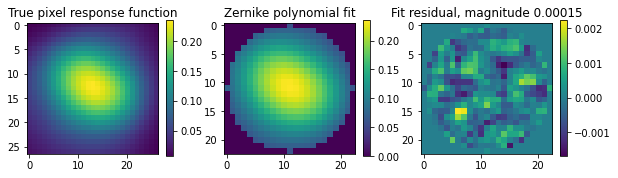

In [43]:
f, axs = plt.subplots(1, 3, figsize=(10,10))
im0 = axs[0].imshow(prf_cut)
axs[0].set_title("True pixel response function")
im1 = axs[1].imshow((pol.ZZ @ x).reshape(23,23))
axs[1].set_title("Zernike polynomial fit")
im2 = axs[2].imshow(prf_cut_circ - (pol.ZZ @ x).reshape(23,23))
res = np.sum((prf_cut_circ - (pol.ZZ @ x).reshape(23,23)) ** 2)
axs[2].set_title("Fit residual, magnitude {}".format(np.round(res, 5)))
f.colorbar(im0, ax=axs[0], shrink=0.25)
f.colorbar(im1, ax=axs[1], shrink=0.25)
f.colorbar(im2, ax=axs[2], shrink=0.25)
#plt.savefig("./zernfit.png")

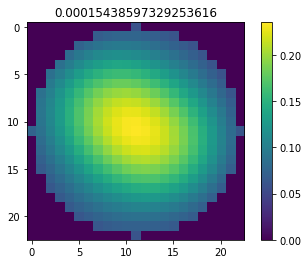

In [44]:
x, res, rank, sv = np.linalg.lstsq(pol.ZZ, (prf_cut_circ.flatten()))
plt.imshow((pol.ZZ @ x).reshape(23,23))
plt.title(res[0])
plt.colorbar()

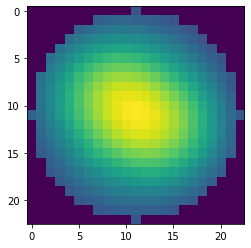

In [45]:
plt.imshow(prf_cut_circ)

In [61]:
pol.ZZ.shape

(121, 28)

In [62]:
xx, yy = np.meshgrid(np.linspace(-1, 1, 117), np.linspace(-1, 1, 117))
pol.make_cart_grid(xx, yy, unit_circle=False)
rho = np.sqrt(np.square(xx) + np.square(yy))
theta = np.arctan2(yy, xx)
r2z = np.einsum('i,ij->ij', rho.flatten() ** 2, pol.ZZ)
c, _, _, _ = np.linalg.lstsq(r2z, -np.log(prf).ravel())

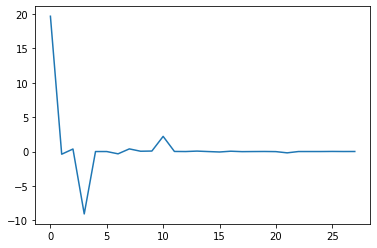

In [63]:
plt.plot(c)

In [64]:
tpf_x, tpf_y = np.meshgrid(np.arange(11), np.arange(11))

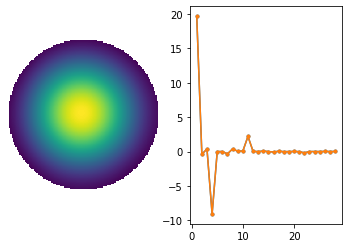

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from zernike import RZern

L, K = 117, 117
ddx = np.linspace(-1.0, 1.0, K)
ddy = np.linspace(-1.0, 1.0, L)
xv, yv = np.meshgrid(ddx, ddy)
pol.make_cart_grid(xv, yv)

c0 = c
Phi = pol.eval_grid(c0, matrix=True)
c1 = pol.fit_cart_grid(Phi)[0]
plt.figure(1)
plt.subplot(1, 2, 1)
plt.imshow(Phi, origin='lower', extent=(-1, 1, -1, 1))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.plot(range(1, pol.nk + 1), c0, marker='.')
plt.plot(range(1, pol.nk + 1), c1, marker='.')

plt.show()


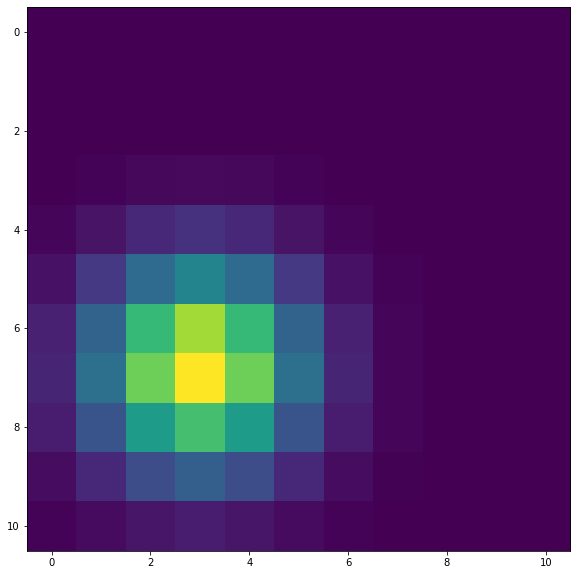

In [67]:
dx, dy = tpf_x - xc[0], tpf_y - (yc[0]-2.7)
plt.figure(figsize=(10,10))
ideal_gaussian = np.exp(-0.25*dx ** 2 -0.25*dy ** 2)
ax = plt.imshow(ideal_gaussian)

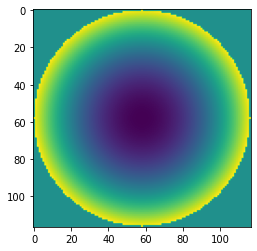

In [68]:
plt.imshow(np.nan_to_num(pol.ZZ[:,3]).reshape(117,117).T)

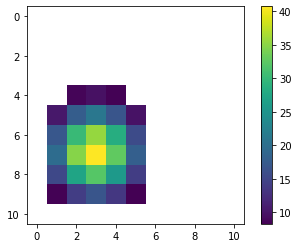

In [71]:
pol.make_cart_grid(dx/3, dy/3) # only do this once per star - not once per star per frame, make sure they're cached
plt.imshow(pol.eval_grid(c).reshape(11,11).T)
plt.colorbar()

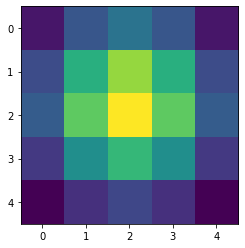

In [72]:
xmask = np.abs(tpf_x - xc[0]) < 3
ymask = np.abs(tpf_y - (yc[0]-2.7)) < 2.5
gaussian_cutout = ideal_gaussian[[xmask * ymask]].reshape(5, 5)
plt.imshow(gaussian_cutout)

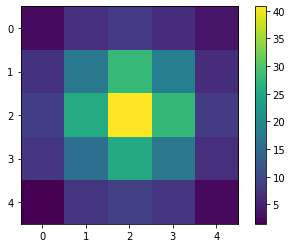

In [74]:
zern_small = RZern(6)
zern_small.make_cart_grid(*np.meshgrid(np.linspace(-1, 1, 5), np.linspace(-1, 1, 5)), unit_circle=False)
x, res, _, _, = np.linalg.lstsq(zern_small.ZZ, gaussian_cutout.ravel())
plt.imshow((zern_small.ZZ @ c).reshape(5,5))
plt.colorbar()